In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext autotime


from ngram import *
from baselines import *
from error_analysis import *
from deep_learning import *

pd.options.mode.chained_assignment = None

Using TensorFlow backend.


### Load Annotated Data

In [2]:
task = 'recipient'
xtype = 'ngams'
ytype = 'empirical_dist'
n_classes = 2

time: 3.07 ms


In [3]:
data = load_comments_and_labels(task)

time: 4min 9s


### NGram Preprocessing

In [4]:
maxlen = 100
max_features = 10000
    
feature_pipeline =  Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,1), analyzer = 'word', max_features = max_features)),
    ('to_sequence', SequenceTransformer(maxlen = maxlen)), 
])

X_comments, _ = assemble_data(data, 'comments', ytype, splits = ['train'])
preprocessor = feature_pipeline.fit(X_comments)
data = apply_transform(data, 'comments', preprocessor, xtype)

X_train, y_train = assemble_data(data, xtype, ytype, splits = ['train'])
X_test, y_test = assemble_data(data, xtype, 'empirical_dist', splits = ['test'])

time: 47.7 s


### Define Model

In [5]:
clf =  KerasClassifier(build_fn=make_conv_rnn, output_dim = n_classes, max_features = max_features, maxlen = maxlen)

time: 3.06 ms


### Hyper-Parameter tuning

In [30]:
# Deep EDP

param_grid = {
    'nb_epoch' : (1,2),
    'batch_size': (100,),
    'dropout': (0.25, 0.5)
}

tune (X_train, y_train, clf, param_grid, roc_scorer, n_jobs=1, verbose=True)

Epoch 1/1
30341/30341 [==============================] - 28s    
Epoch 1/2
70793/70793 [==============================] - 244s - loss: 0.0680 - acc: 0.9520   
Epoch 2/2
30341/30341 [==============================] - 30s    
Epoch 1/1
30341/30341 [==============================] - 33s    
Epoch 1/2
70793/70793 [==============================] - 328s - loss: 0.0716 - acc: 0.9490   
Epoch 2/2
30341/30341 [==============================] - 30s    

Best parameters set found:
{'nb_epoch': 2, 'dropout': 0.25, 'batch_size': 100} 0.972344856198


Grid scores:
0.96992 (+/-0.00000) for {'nb_epoch': 1, 'dropout': 0.25, 'batch_size': 100}
0.97234 (+/-0.00000) for {'nb_epoch': 2, 'dropout': 0.25, 'batch_size': 100}
0.96751 (+/-0.00000) for {'nb_epoch': 1, 'dropout': 0.5, 'batch_size': 100}
0.97080 (+/-0.00000) for {'nb_epoch': 2, 'dropout': 0.5, 'batch_size': 100}
time: 31min 59s


Seems, like we don't need to regularize at one epoch. Lets try more epochs.

### Eval Conv RNN

In [9]:
conv_rnn =  KerasClassifier(build_fn=make_conv_rnn,
                            output_dim = n_classes,
                            max_features = max_features,
                            maxlen = maxlen,
                            batch_size = 100,
                            nb_epoch = 2,
                            dropout = 0.25)
conv_rnn.fit(X_train, y_train)
roc_df, spearman_df = test_cross(conv_rnn, data, xtype)

Epoch 1/2
71009/71009 [==============================] - 381s - loss: 0.0950 - acc: 0.9512   
Epoch 2/2
23668/23668 [==============================] - 29s    
time: 13min 34s


In [10]:
roc_df

,random,blocked,both
user,0.991508,0.950181,0.962723
article,0.983273,0.973071,0.979804
both,0.986596,0.962066,0.972147


time: 31 ms


In [11]:
spearman_df

,random,blocked,both
user,0.271530,0.683174,0.645475
article,0.228076,0.485293,0.417313
both,0.274896,0.663095,0.601349


time: 8.42 ms


### Check Calibration

23668/23668 [==============================] - 29s    


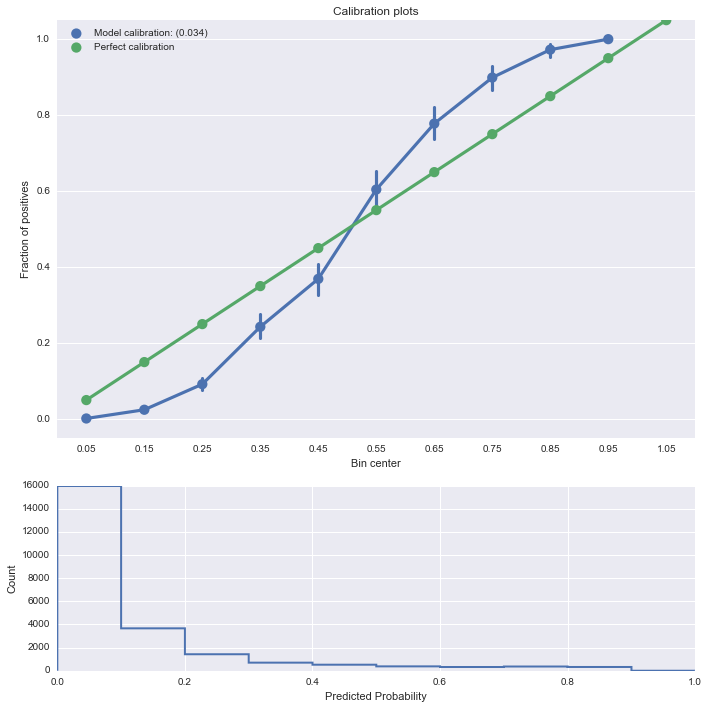

time: 30.3 s


In [12]:
y_test_oh = one_hot(y_test)
y_pred_ed = conv_rnn.predict_proba(X_test)

if n_classes > 2:
    classes = range(n_classes)
else:
    classes = [1]

for i in classes:
    plt.figure()
    calibration_curve_plotter(y_test_oh[:, i], y_pred_ed[:, i])
    plt.show()